In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem.isri import ISRIStemmer  
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier 
import pickle
import itertools 
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.svm import SVC, NuSVC
import os
import glob 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

In [ ]:
folder = 'data/Negative'
neg_list=[]
for n in os.listdir(folder):
    with open(os.path.join(folder, n),'r',encoding='utf-8',errors='ignore') as file:
        for s in file:
            
            neg_list.append(s.strip("\ufeff").strip())

In [ ]:
neg_list[3:5]

['شو هاد البرنامج معقول عرضوه على القنوات!!!!!!!!!!!!!',
 'للأسف البعض يعتقد ان المفاعل النووي سيحل مشاكلنا الاقتصادية و لكن الأردن لا يمتلك موارد مالية و هذا يعني الحاجة لشريك أجنبي "كما اعلنت هيئة الطاقة" يملك غالبية الأسهم كما في تركيا على سبيل المثال و ذلك يعني ان هذا الشريك سيمتلك الجزء الأكبر من المفاعل و لن يكون ملك للأردن و بالتالي ستقوم الحكومة ايضاً بدفع تكاليف الكهرباء للمستثمر و بالتالي المفاعل النووي لن يوفر لك الكهرباء بسعر قليل']

In [ ]:
len(neg_list)

1000

In [ ]:
pos_list=[]
for f in glob.glob('data/Positive/*.txt'):
    with open(f,'r',encoding='utf-8',errors='ignore') as file:
        for s in file:
            
            pos_list.append(s.strip("\ufeff").strip())

In [ ]:
pos_list[3:6]

['كلامك جميل ورائع',
 'و خير الكلام ما قل و دل',
 'ولا تنسو تبسمك في وجه اخيك صدقه']

In [ ]:
len(pos_list)

1000

In [ ]:
tweets=pos_list[:1000]+neg_list[:1000]

In [ ]:
tweets[900:905]

['اللهم ثبته على دين الاسلام اللهم يا مقلب القلوب ثبت قلبي على دينك',
 'و الله بذل نفسي مرة و اتنين و خمسين عشان الغرام الحلال احلى لكن مين يحس و يفهم و يقدر',
 'أهلا وسهلا بك بيننا يا طارق',
 'اللهم إنى أقسمت عليك بك أن تهدى شباب المسلمين وتنور قلوبهم كما أنعمت على طارق بنعمة اﻹسﻻم',
 'الهم سدد خطاه وجعل الاسلام نور لكل البشر']

In [ ]:
labels=np.append(np.ones((len(tweets[:1000]))),np.zeros((len(tweets[1000:]))))

In [ ]:
data=pd.DataFrame({'tweets':tweets,'labels':labels})
data.head()

,tweets,labels
0,حقا,1.0
1,صح جدا,1.0
2,اه و النعمة,1.0
3,كلامك جميل ورائع,1.0
4,و خير الكلام ما قل و دل,1.0


In [ ]:
data=data.sample(frac=1).reset_index(drop=True)

In [ ]:
pd.set_option('display.max_colwidth',100)
data.head()

,tweets,labels
0,و الله حرام الناس مش لاقيه توكل حتى ترفعو البنزين,0.0
1,اذا اليابان اكلت هوا من النووي كيف احنا,0.0
2,دربي زدني ثقتا بك فانه لايخيب من وثق بك,1.0
3,هذول مساجين ولا ايش,0.0
4,هذه مشكلة الذي يغني كثيراً في الحمام ويتصور انه اصبح مطرب,0.0


# Preprocessing

In [ ]:
stopwords.words("arabic")[1:6]

['إذا', 'إذما', 'إذن', 'أف', 'أقل']

In [ ]:
def processor_text(text):
    words=text.split()
    stopwords_list=stopwords.words('arabic')
    new_stopwords=[]
    for w in stopwords_list:
        
        new_stopwords.append(re.sub('[ي].*','ى' ,w))
    for w in range(len(new_stopwords)):
        new_stopwords[w]=re.sub('[إأٱآا]','ا', new_stopwords[w]) 
    all_stopwords= stopwords_list+ new_stopwords  
    new_list_stopwords=[
        'اني','وانا','انك','لان',"انو",'انني','عندى','عندي','__','من'\
        ,'اليه','مني','اي','وانت','لاني','انه','دا','انك',"عليكم","الي","وبالتالي","",\
        'اللي','ال','لان','مو','بن','باي','علي',"منهم","هيك","شي","شئ","شيء"]
    no_stopwords=[]
    for w in words:
        if (w not in all_stopwords and w not in new_list_stopwords ) : #remove stopwords
            no_stopwords.append(w)
    text=' '.join(no_stopwords)
    
    text = re.sub("[إأٱآا]", "ا", text) #Normaliza text
    text = re.sub("ى", "ي" ,text)
#     text = re.sub("ؤ", "ء", text)
#     text = re.sub("ئ", "ء", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text="".join(text)
    text=' '.join(
        re.sub(r"(@[A-Za-z0-9]+)|(http\S+)|#|(\d[0-9]?)|[A-Za-z]+|(\W*\b\w{1}\b)|(\.).*?|(\،).*?|(?:\…).*?|(?:\؟).*?|(?:\؛).*?", " ", text).split())#remove irrelevant text
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,  
                               reduce_len=True)#this method keeps the emojis. we consider emojis because emojis
# #are often used to enhance or modified a textual content by
# #adding information at the emotional level, at the end of the sentence.  
    text_tokens = tokenizer.tokenize(text)
    cleaned_words=[]
    for word in text_tokens:

        if word not in string.punctuation:
            cleaned_words.append(word)

    sentence=" ".join(cleaned_words)

    return sentence

In [ ]:
processor_text('💔 احنا ما بدنا اياه لانا ما منفهم المفاعل النووي فوق طاقتنا صعب علينا و بكرة بذكركم و سألوا الباص ...')

'💔 احنا بدنا اياه لانا منفهم المفاعل النووي فوق طاقتنا صعب علينا بكرة بذكركم سالوا الباص'

In [ ]:
data['cleaned_tweets']=data.tweets.apply(processor_text)

In [ ]:
data['cleaned_tweets'].sample(6)

1316                                                                        اللهم اغفر لامة المسلمين اجمعين
510                                                                                           والله بلسه يع
294                                                                الهم سدد خطاه وجعل الاسلام نور لكل البشر
1942    انتو ادري الموضوع مش لصالح الصحه العامه بعدين مش اشي بتعملو امريكا لازم نعملو نصير امعه اصلا احن...
1259                        مش النووي ان صار اظنش اسرائيل تسمح باقامته بهالسهولة بيعني احنا متطورين متقدمين
357                                                                         يقارن بينه وبين مرسي يبقي متخلف
Name: cleaned_tweets, dtype: object

# Visualization

In [ ]:
neg_tweets=data[data.labels==0]
pos_tweets=data[data.labels==1]

In [ ]:
print(f"Number of words before pre-processing: {len(' '.join(w for w in data.tweets))}")
print('-'*50)      
print(f"Number of words after pre-processing: {len(' '.join(w for w in data.cleaned_tweets))}")      
print('-'*50)      
print(f"Number of words in negative tweets: {len(' '.join(w for w in neg_tweets.cleaned_tweets))}") 
print('-'*50)      
print(f"Number of words in postive tweets: {len(' '.join(w for w in pos_tweets.cleaned_tweets))}")                                             

Number of words before pre-processing: 96101
--------------------------------------------------
Number of words after pre-processing: 80106
--------------------------------------------------
Number of words in negative tweets: 47632
--------------------------------------------------
Number of words in postive tweets: 32473


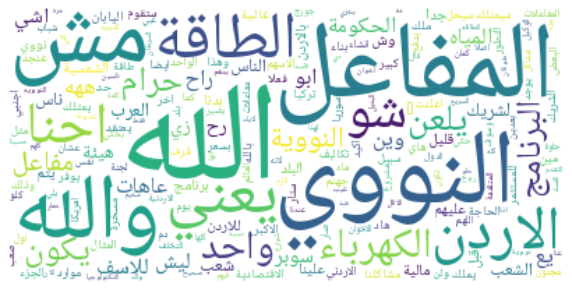

In [ ]:
from collections import Counter

from wordcloud import WordCloud         
# -- Arabic text dependencies
from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi
neg_text=" ".join(row  for row in neg_tweets.cleaned_tweets)
rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter(neg_text.split())
counts = {rtl(k):v for k, v in COUNTS.most_common(300)}

font_file = 'NotoNaskhArabic-Regular.ttf' 
plt.figure(figsize=(10,14))
wordcloud = WordCloud(font_path=font_file, background_color="white").generate_from_frequencies(counts)
plt.imshow(wordcloud, interpolation="bilinear")
wordcloud.to_file('most_frequent_words_in_negative_tweets.png')
plt.axis("off");

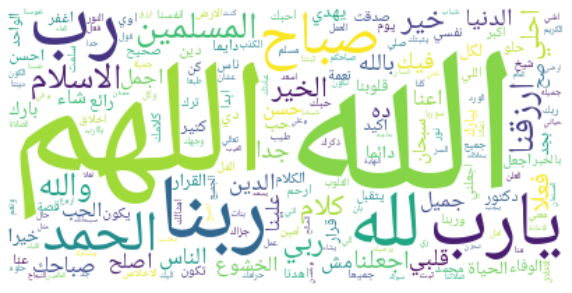

In [ ]:
pos_text=" ".join(row  for row in pos_tweets.cleaned_tweets)
rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter(pos_text.split())
counts = {rtl(k):v for k, v in COUNTS.most_common(300)}

font_file = 'NotoNaskhArabic-Regular.ttf' 
plt.figure(figsize=(10,14))
wordcloud = WordCloud(font_path=font_file, background_color="white").generate_from_frequencies(counts)
plt.imshow(wordcloud, interpolation="bilinear")
wordcloud.to_file('most_frequent_words_in_positive_tweets.png')
plt.axis("off");

# STEMMING

In [ ]:
data.cleaned_tweets.sample()

1114    اللهم اجعلنا يتمتعون بروح ريحان
Name: cleaned_tweets, dtype: object

In [ ]:
# stemming 
def stemming(text):
    st=ISRIStemmer()
    stemming_words=[]
    words=word_tokenize(text)
    for w in words:
        stemming_words.append(st.stem(w))
    return " ".join(stemming_words)

In [ ]:
stemming(processor_text('خلص اخرسن قرفت اكتر منكن'))

'خلص خرس قرف كتر نكن'

In [ ]:
data.cleaned_tweets=data.cleaned_tweets.apply(stemming)

# Bag of words, TF-IDF 

In [ ]:
X_train, X_test, y_train ,y_test = \
    train_test_split(data['cleaned_tweets'], data["labels"], test_size=0.25, random_state=1000)

In [ ]:
vectorizer=CountVectorizer(min_df=1,ngram_range=(1,1))
features=vectorizer.fit_transform(X_train)

In [ ]:
transformer=TfidfTransformer(norm='l2',
                                 smooth_idf=True,
                                 use_idf=True
    )
X_train=transformer.fit_transform(features)

In [ ]:
X_test=vectorizer.transform(X_test)
X_test=transformer.transform(X_test)

# Models

### 1- Naive Bayes

In [ ]:
naive_classifier=MultinomialNB().fit(X_train, y_train)

In [ ]:
naive_pred = naive_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, naive_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88       246
         1.0       0.87      0.91      0.89       254

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



# 2- Random forest 

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [ ]:
rfc=RandomForestClassifier(n_estimators=200,min_samples_split=10)
rfc.fit(X_train, y_train)
randomforest_prediction= rfc.predict(X_test)

### 3- BaggingClassifier

In [ ]:
bag_mod = BaggingClassifier(n_estimators=100)
bag_mod.fit(X_train,y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=100,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [ ]:
bag_pred=bag_mod.predict(X_test)

# 4-AdaBoost Classifier

In [ ]:
ada_mod = AdaBoostClassifier(n_estimators=400,learning_rate=.1)

In [ ]:
ada_mod.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=400, random_state=None)

In [ ]:
ada_mod_pred=ada_mod.predict(X_test)

# 4- SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
SDG = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
SDG.fit(X_train, y_train)
SDG_pred =SDG.predict(X_test)

# Evaluate which classifier has the best scores

In [ ]:
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('Precision score: ', format(precision_score(y_true, preds)))
        print('Recall score: ', format(recall_score(y_true, preds)))
        print('F1 score: ', format(f1_score(y_true, preds)))
        print('\n\n')
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('Precision score ' + model_name + ' :', format(precision_score(y_true, preds)))
        print('Recall score ' + model_name + ' :', format(recall_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(f1_score(y_true, preds)))
        print('\n\n')

In [ ]:
# Naive Bayes Classifier scores
print_metrics(y_test, naive_pred, 'Naive Bayes')

# SGDClassifier  scores
print_metrics(y_test, SDG_pred, 'SGDClassifier')
# Print Random Forest scores
print_metrics(y_test, randomforest_prediction, 'Random Forest')

# Print AdaBoost scores
print_metrics(y_test, ada_mod_pred, 'AdaBoost')

# Print Bagging scores
print_metrics(y_test, bag_pred, 'Bagging')

Accuracy score for Naive Bayes : 0.896
Precision score Naive Bayes : 0.8832116788321168
Recall score Naive Bayes : 0.9236641221374046
F1 score Naive Bayes : 0.9029850746268656



Accuracy score for SGDClassifier : 0.886
Precision score SGDClassifier : 0.8867924528301887
Recall score SGDClassifier : 0.8969465648854962
F1 score SGDClassifier : 0.8918406072106262



Accuracy score for Random Forest : 0.842
Precision score Random Forest : 0.8674698795180723
Recall score Random Forest : 0.8244274809160306
F1 score Random Forest : 0.8454011741682974



Accuracy score for AdaBoost : 0.852
Precision score AdaBoost : 0.8790322580645161
Recall score AdaBoost : 0.8320610687022901
F1 score AdaBoost : 0.8549019607843138



Accuracy score for Bagging : 0.836
Precision score Bagging : 0.86
Recall score Bagging : 0.8206106870229007
F1 score Bagging : 0.83984375





# Test the best model with new tweets

In [ ]:
def predict_sentence(sentence): 
    neg=0
    pos=0
    test_sentence= sentence
    words=test_sentence.split(" ")
    for word in words:
        vec_tweets=transformer.transform(vectorizer.transform([stemming(processor_text(word))]))
        class_result=naive_classifier.predict(vec_tweets)
        if class_result==0:
            neg=neg+1
        if class_result==1:
            pos=pos+1
    print("positive: "+str(float(pos)/len(words)))  
    print("Negative: "+str(float(neg)/len(words)))        

In [ ]:
predict_sentence(' ولكن من يدري، عندما نتحرّك وسط مخابرات وجواسيس \
مزدوجين وضبّاط خونة وكنسيّين مذنبين، كلّ شيء ممكنا')

positive: 0.17647058823529413
Negative: 0.8235294117647058


In [ ]:
predict_sentence('ربنا يكرمك ويجزيك خير')

positive: 1.0
Negative: 0.0
